1. Importing the Libraries

In [43]:
import shap

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as tickertr

from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, f1_score,confusion_matrix,accuracy_score,classification_report

2. Loading & Manipulating the Dataset

In [2]:
# Loading the data

df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
df.shape

(6362620, 11)

Information about dataset, paysim1:

URL of Kaggle Dataset page: https://www.kaggle.com/ntnu-testimon/paysim1

Here are the variables in the datasets as well as their descriptions:

- step - integer - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - string/categorical - type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - float - amount of the transaction in local currency.

- nameOrig - string - customer who initiated the transaction

- oldbalanceOrg - float initial balance before the transaction

- newbalanceOrig - float - new balance after the transaction

- nameDest - string - customer who is the recipient of the transaction

- oldbalanceDest - float - initial balance of recipient before the transaction.

- newbalanceDest - float - new balance of recipient after the transaction.

- isFraud - boolean/binary - determines if transaction is fraudulent (encoded as 1) or valid (encoded as 0)

- isFlaggedFraud - boolean/binary - determines if transaction is flagged as fraudulent (encoded as 1) or not flagged at all (encoded as 0). An observation is flagged if the transaction is fraudulent and it involved a transfer of over 200,000 in the local currency.

In [4]:
# Random samples from the dataset

df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1600304,156,CASH_IN,214628.41,C558150384,56224.00,270852.41,C2093094872,4545286.15,4330657.75,0,0
3545803,260,CASH_IN,159956.29,C490473085,407714.82,567671.11,C608768229,620152.31,460196.02,0,0
4279535,307,CASH_IN,30163.01,C1396922146,8350504.12,8380667.13,C180252410,1451311.92,1421148.91,0,0
1946102,177,CASH_IN,173225.88,C1393661348,6426368.72,6599594.60,C599081549,293853.69,120627.80,0,0
1529212,153,PAYMENT,9089.77,C1964532902,4078.24,0.00,M95514965,0.00,0.00,0,0


In [5]:
# Column names are not properly Camel Cased

df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

3. EDA

In [6]:
# Column data type summary

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# Column wise null values chcek

df.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldBalanceOrig    False
newBalanceOrig    False
nameDest          False
oldBalanceDest    False
newBalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

In [8]:
# Summary of the dataset

df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Key Takeaways:

- There are no missing values
- There are just over 6 million observations
- There are 11 variables
- Most transactions involve amounts less than 1 million euros.
- Most observations in the dataset are of valid transactions, so any patterns related to identifying fraud transactions may be hard to see, data is also unbalanced.
- From the sample of observations, there are many instances where what happens to the recipient account (oldbalanceDest, newbalanceDest) does not make sense.

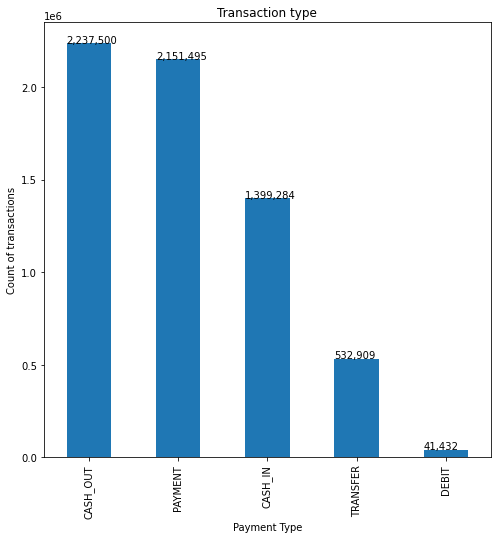

In [9]:
# Plot showing counts of transaction types

f, ax = plt.subplots(1, 1, figsize=(8, 8))
df['type'].value_counts().plot(kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
ax.set_xlabel("Payment Type")
ax.set_ylabel("Count of transactions")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
plt.show()

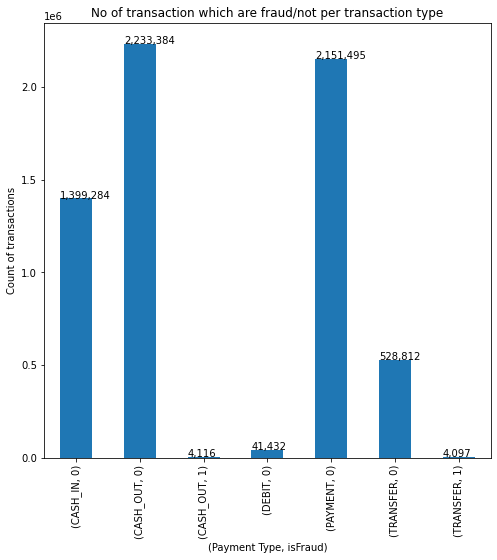

In [10]:
# Plot showing count of transaction which are fraud/not per transaction type

ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar',figsize=(8,8))
ax.set_title("No of transaction which are fraud/not per transaction type")
ax.set_xlabel("(Payment Type, isFraud)")
ax.set_ylabel("Count of transactions")

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
plt.show()

In [11]:
list(df.loc[df.isFraud == 1].type.drop_duplicates().values)

['TRANSFER', 'CASH_OUT']

We find that of the five types of transactions, fraud occurs only in two of them : 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash.

In [12]:
# Counts of fraudulent TRANSFERs and fraudulent CASH_OUTs

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print (' The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer))) 

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout))) 

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [13]:
# Count of isFlaggedFrauds is set

print (' The number of isFlaggedFrauds set to 1 = {}'.\
       format(len(df.loc[df['isFlaggedFraud']==1]))) 

 The number of isFlaggedFrauds set to 1 = 16


In [14]:
df.loc[df['isFlaggedFraud']==1].describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,16.000000,1.600000e+01,1.600000e+01,1.600000e+01,16.0,16.0,16.0,16.0
mean,537.562500,4.861598e+06,7.817869e+06,7.817869e+06,0.0,0.0,1.0,1.0
std,181.895196,3.572499e+06,6.972669e+06,6.972669e+06,0.0,0.0,0.0,0.0
min,212.000000,3.538742e+05,3.538742e+05,3.538742e+05,0.0,0.0,1.0,1.0
25%,415.500000,2.242749e+06,3.013980e+06,3.013980e+06,0.0,0.0,1.0,1.0
50%,601.500000,4.234245e+06,4.923043e+06,4.923043e+06,0.0,0.0,1.0,1.0
75%,678.750000,7.883451e+06,1.212835e+07,1.212835e+07,0.0,0.0,1.0,1.0
max,741.000000,1.000000e+07,1.958504e+07,1.958504e+07,0.0,0.0,1.0,1.0


In [15]:
len(df.loc[(df['amount'] > 200000)])

1673570

In [16]:
df.loc[df['isFlaggedFraud']==1]

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. In fact, as shown below, isFlaggedFraud can remain not set despite this condition being met.

In [17]:
dfTransfer = df[df['type'] == 'TRANSFER']
dfFlagged = df[df.isFlaggedFraud == 1]

In [18]:
print('The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and\
 newBalanceDest = 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) 

The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. This is presumably because the transaction is halted. Interestingly, oldBalanceDest = 0 in every such transaction. However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

In [19]:
print('Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0)].oldBalanceOrig.max())]))

Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs: [0.0, 59585040]


isFlaggedFraud being set cannot be thresholded on oldBalanceOrig since the corresponding range of values overlaps with that for TRANSFERs where isFlaggedFraud is not set 

In [20]:
print('No of originators of transactions flagged as fraud transacted more than \
once is: {}'.\
format(sum(df.loc[df['isFlaggedFraud']==1]['nameOrig'].value_counts() > 1)))

print('\nNo of destinations of transactions flagged as fraud transacted more than \
once is: {}'.\
format(sum(df.loc[df['isFlaggedFraud']==1]['nameDest'].value_counts() > 1)))

No of originators of transactions flagged as fraud transacted more than once is: 0

No of destinations of transactions flagged as fraud transacted more than once is: 0


Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

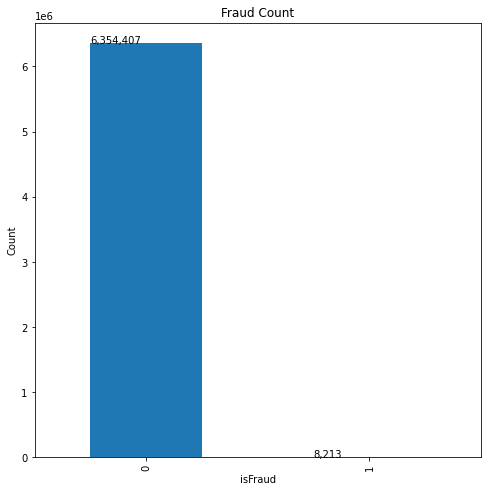

In [21]:
# Plot showing counts of payment type

f, ax = plt.subplots(1, 1, figsize=(8, 8))
df['isFraud'].value_counts().plot(kind='bar', title="Fraud Count", ax=ax, figsize=(8,8))
ax.set_xlabel("isFraud")
ax.set_ylabel("Count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
plt.show()

4. Data Cleaning

From the exploratory data analysis (EDA), we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis.



In [22]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['isFraud']
del X['isFraud']

# Eliminate columns shown to be irrelevant for analysis in the EDA
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) 

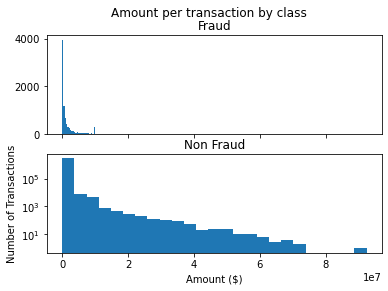

In [23]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 25
ax1.hist(Xfraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(XnonFraud.amount, bins = bins)
ax2.set_title('Non Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

Less number of transaction amount in fraud comapare to non fraud data

In [24]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


5. Machine Learning Modeling

In [64]:
# Helper function to train model, evaluate model and generate consistent reports

def model_result(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification_report")
    print(classification_report(y_test,y_pred))

In [26]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=42, shuffle=False)

Performance Metric selection:

- Since the data is highly skewed, I prefered precision-recall curve(AUPRC) over (AUROC).
- F1 score 
- Confusion matrix

In [28]:
%%time

dt_clf1 = DecisionTreeClassifier()
dt_clf1.fit(X_train, y_train)
print ('Test')
model_result(dt_clf1,X_test,y_test)

Test
AUPRC : 0.8078237615095007
F1 - score : 0.896858768241405
Confusion_matrix : 
[[549622    200]
 [   634   3626]]
accuracy_score
0.9984948076277519
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    549822
           1       0.95      0.85      0.90      4260

    accuracy                           1.00    554082
   macro avg       0.97      0.93      0.95    554082
weighted avg       1.00      1.00      1.00    554082

Wall time: 26.4 s


In [27]:
%%time

r_clf1=RandomForestClassifier()
r_clf1.fit(X_train,y_train)
print ('Test')
model_result(r_clf1,X_test,y_test)

Test
AUPRC : 0.9391744188157494
F1 - score : 0.8514878147300391
Confusion_matrix : 
[[549817      5]
 [  1098   3162]]
accuracy_score
0.9980093199201562
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    549822
           1       1.00      0.74      0.85      4260

    accuracy                           1.00    554082
   macro avg       1.00      0.87      0.93    554082
weighted avg       1.00      1.00      1.00    554082

Wall time: 10min 32s


In [29]:
%%time

xg_clf1 = XGBClassifier()
xg_clf1.fit(X_train, y_train)
print ('Test')
model_result(xg_clf1,X_test,y_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:46:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test
AUPRC : 0.9798203805706943
F1 - score : 0.853724119386932
Confusion_matrix : 
[[549819      3]
 [  1085   3175]]
accuracy_score
0.9980363917254125
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    549822
           1       1.00      0.75      0.85      4260

    accuracy                           1.00    554082
   macro avg       1.00      0.87      0.93    554082
weighted avg       1.00      1.00      1.00    554082

Wall time: 1min 20s


6. Feature Engineering

In [30]:
print('The fraction of fraudulent transactions with \'oldBalanceOrig\' = \
\'newBalanceOrig\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceOrig == 0) & \
(Xfraud.newBalanceOrig == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceOrig\' = \
newBalanceOrig\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceOrig == 0) & \
(XnonFraud.newBalanceOrig == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))

The fraction of fraudulent transactions with 'oldBalanceOrig' = 'newBalanceOrig' = 0 although the transacted 'amount' is non-zero is: 0.0030439547059539756

The fraction of genuine transactions with 'oldBalanceOrig' = newBalanceOrig' = 0 although the transacted 'amount' is non-zero is: 0.4737321319703598


In [31]:
print('The fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))

The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we take the data-imputation of a step further and create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. These new features turn out to be important in obtaining the best performance.



In [32]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

7. Machine Learning Modeling with Feature Engineering

In [33]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2,random_state=42, shuffle=False)

In [41]:
%%time

dt_clf2 = DecisionTreeClassifier()
dt_clf2.fit(X_train, y_train)
print ('Test')
model_result(dt_clf2,X_test,y_test)

Test
AUPRC : 0.9983660520169743
F1 - score : 0.9991781143595163
Confusion_matrix : 
[[549820      2]
 [     5   4255]]
accuracy_score
0.9999873664908804
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    549822
           1       1.00      1.00      1.00      4260

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

Wall time: 23.6 s


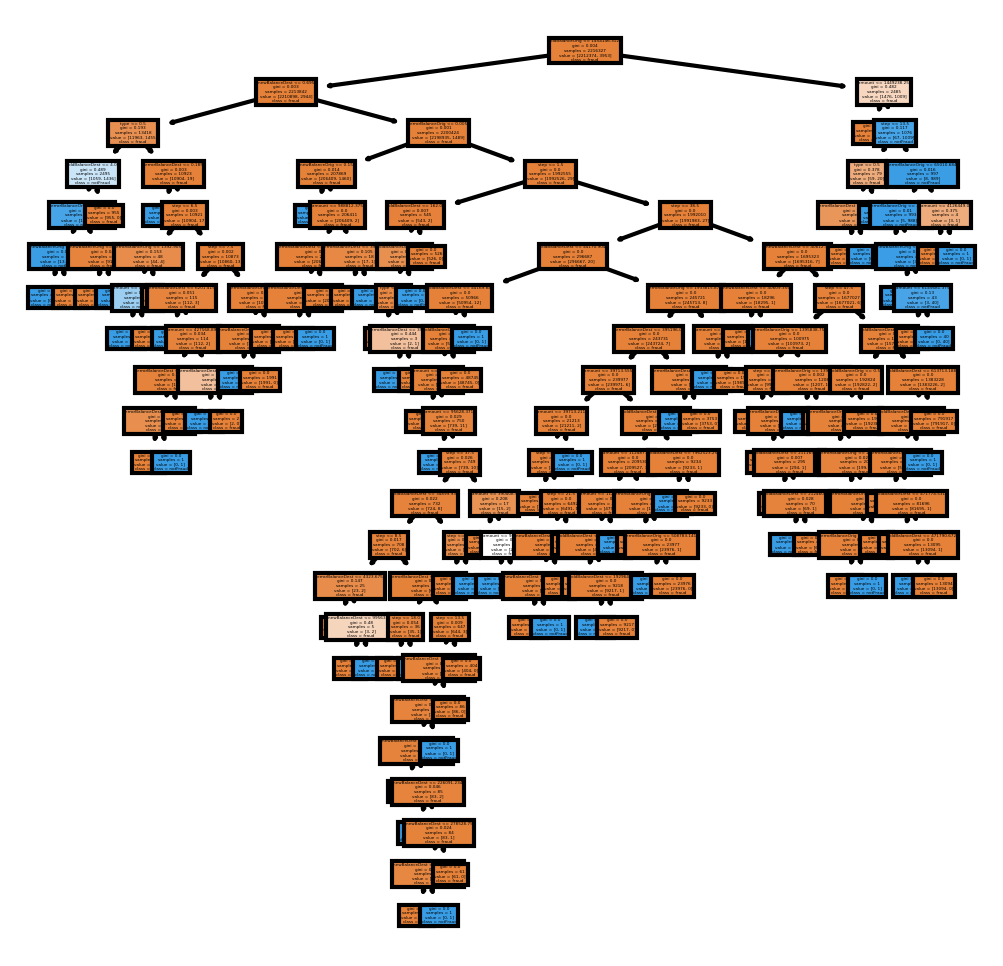

In [51]:
fn= X.columns
cn=['fraud','notFraud']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt_clf2,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('DecisionTree.png')

In [56]:
feature_importances_dt = pd.DataFrame(dt_clf2.feature_importances_, index =X.columns,  columns=['importance']).sort_values('importance', ascending=False)

<AxesSubplot:>

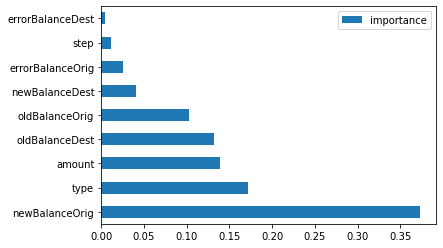

In [57]:
feature_importances_dt.plot(kind='barh')

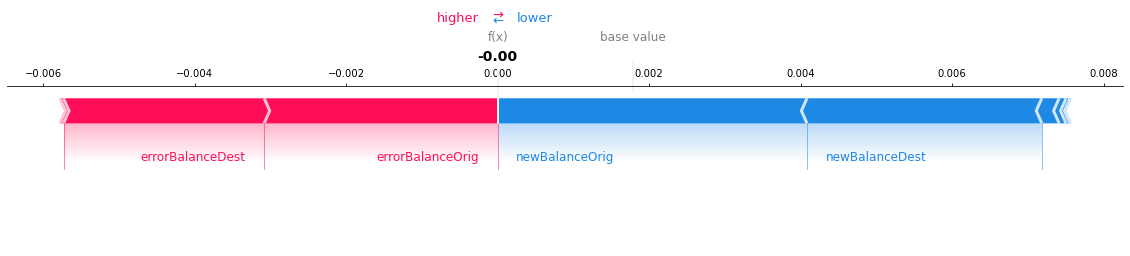

In [52]:
explainer = shap.TreeExplainer(dt_clf2)
i = 1 
shap_value = explainer.shap_values(X_test.iloc[i, :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

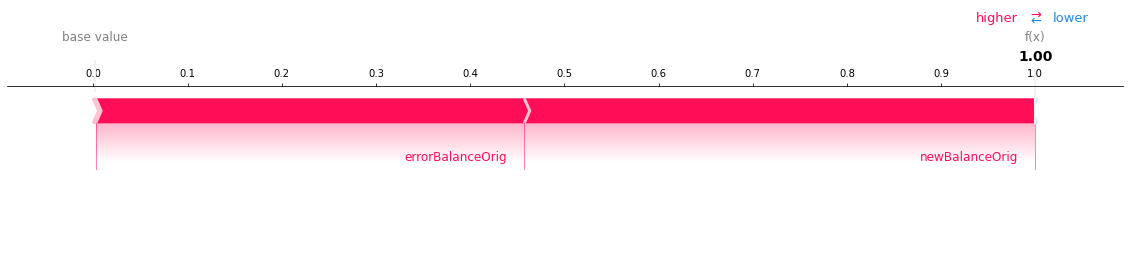

In [54]:
explainer = shap.TreeExplainer(dt_clf2)
i = -1
shap_value = explainer.shap_values(X_test.iloc[i, :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

In [34]:
%%time

r_clf2=RandomForestClassifier()
r_clf2.fit(X_train,y_train)
print ('Test')
model_result(r_clf2,X_test,y_test)

Test
AUPRC : 0.9999998898055218
F1 - score : 0.9997652030993192
Confusion_matrix : 
[[549822      0]
 [     2   4258]]
accuracy_score
0.9999963904259659
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    549822
           1       1.00      1.00      1.00      4260

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

Wall time: 9min 47s


8. Feature Importances in the trained model

In [35]:
feature_importances = pd.DataFrame(r_clf2.feature_importances_, index =X.columns,  columns=['importance']).sort_values('importance', ascending=False)

<AxesSubplot:>

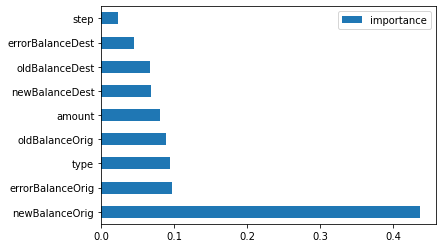

In [36]:
feature_importances.plot(kind='barh')

9. Visualizing few datapoints using SHAP library 

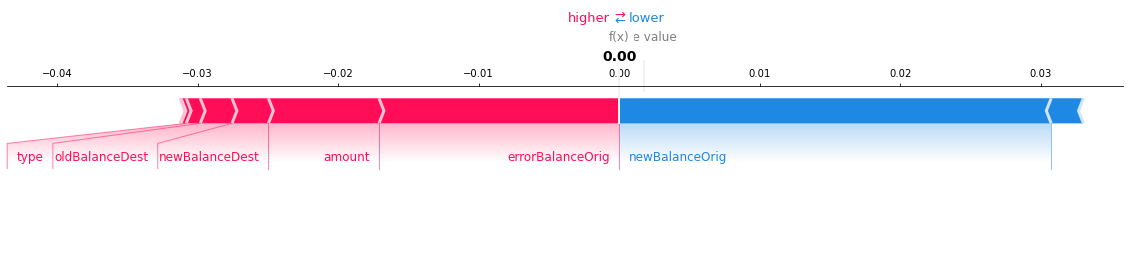

In [37]:
explainer = shap.TreeExplainer(r_clf2)
i = 1 
shap_value = explainer.shap_values(X_test.iloc[i, :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

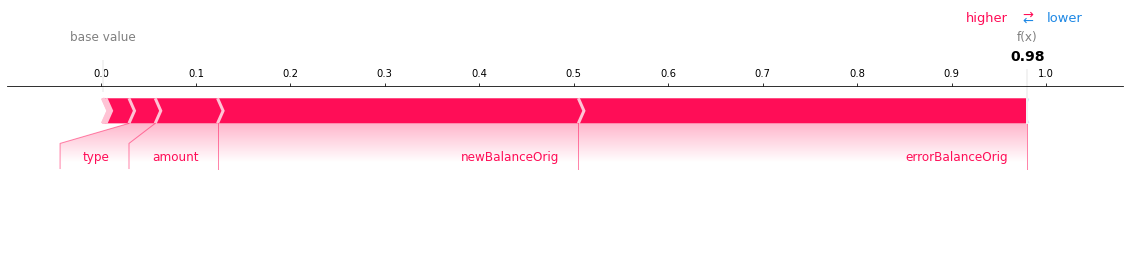

In [39]:
explainer = shap.TreeExplainer(r_clf2)
i = -1 
shap_value = explainer.shap_values(X_test.iloc[i, :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

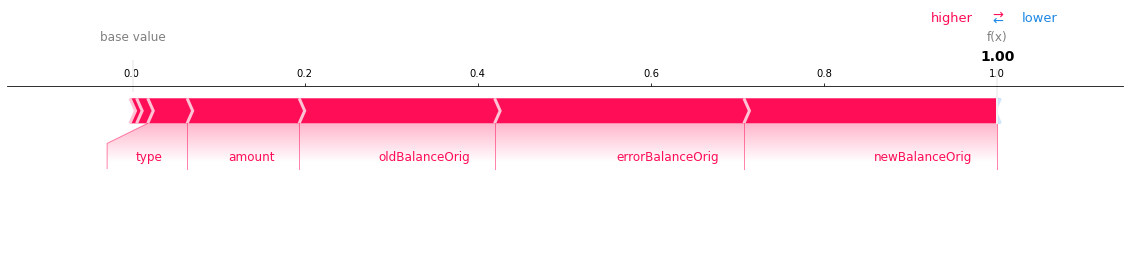

In [40]:
explainer = shap.TreeExplainer(r_clf2)
i = -3 
shap_value = explainer.shap_values(X_test.iloc[i, :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

In [42]:
%%time

xg_clf2 = XGBClassifier()
xg_clf2.fit(X_train, y_train)
print ('Test')
model_result(xg_clf2,X_test,y_test)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[23:57:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test
AUPRC : 0.999999944909227
F1 - score : 0.9997652030993192
Confusion_matrix : 
[[549822      0]
 [     2   4258]]
accuracy_score
0.9999963904259659
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    549822
           1       1.00      1.00      1.00      4260

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

Wall time: 1min 14s
